# Laboratorio 1: Detección de phishing

- Pedro Pablo Guzmán Mayen 22111
- Javier Andres Chen 22153

## Parte 1 - Ingeniería de características

### Exploración de datos

1. Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones.

In [39]:
import pandas as pd


df = pd.read_csv('dataset_pishing.csv')


df.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


Como vemos, el dataset contiene 2 columnas, status la cuál indica si el url es legítimo o no y la columna que contiene el url.

2. Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como “pishing”. ¿Está balanceado el dataset?

In [40]:
df['status'].value_counts()

,count
status,
legitimate,5715
phishing,5715


El dataset si está balanceado pues hay la misma cantidad de urls maliciosas y no maliciosas.

**Derivacion de caracteristicas**

1. **¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?**

a) Detección en tiempo real sin descargar contenido:

* No requiere acceder al contenido de la página web, lo que evita riesgos de  seguridad
* Es significativamente más rápido ya que no necesita descargar HTML, CSS, JavaScript o imágenes

b) Eficiencia computacional:

* Requiere menos recursos del sistema
* Permite procesar grandes volúmenes de URLs rápidamente

c) Independencia de servicios de terceros:
* Evita retrasos de red causados por servicios externos
* Funciona incluso cuando servicios de terceros están caídos o son lentos


2. **¿Qué características de una URL son más prometedoras para la detección de phishing?**

a) Características de longitud:

* Longitud total de la URL
* Longitud del hostname/dominio

b) Entropía:

* Entropía de Shannon de caracteres no-alfanuméricos (propuesta clave)
Entropía relativa
* Mide la distribución/desorden de caracteres especiales

c) Características del dominio:

* Presencia de dirección IP en lugar de nombre de dominio
* Posición del TLD (si aparece en path o subdomain es sospechoso)
* Número de subdominios (phishing usa más)

d) Características estructurales:

* Uso de HTTPS (aunque atacantes ahora también lo usan - 78% según estudios)
* Presencia de puertos no estándar
* Uso de servicios de acortamiento de URLs

In [41]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from collections import Counter
import math

In [42]:
# Cargar el dataset
df = pd.read_csv('dataset_pishing.csv')

# FUNCIONES DE EXTRACCIÓN DE CARACTERÍSTICAS

# 1. LONGITUD DE LA URL COMPLETA
def url_length(url):
    return len(url)

# 2. LONGITUD DEL DOMINIO/HOSTNAME
def domain_length(url):
    parsed = urlparse(url)
    return len(parsed.netloc)

# 3. LONGITUD DEL PATH
def path_length(url):
    parsed = urlparse(url)
    return len(parsed.path)

# 4. NÚMERO DE PUNTOS (.)
def count_dots(url):
    return url.count('.')

# 5. NÚMERO DE GUIONES (-)
def count_hyphens(url):
    return url.count('-')

# 6. NÚMERO DE CARACTERES ESPECIALES
def count_special_chars(url):
    special_chars = ['@', '?', '&', '=', '_', '~', '%', '*', '#', '$']
    return sum([url.count(char) for char in special_chars])

# 7. PRESENCIA DE DIRECCIÓN IP
def has_ip_address(url):
    parsed = urlparse(url)
    domain = parsed.netloc
    ip_pattern = re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}')
    return 1 if ip_pattern.search(domain) else 0

# 8. NÚMERO DE SUBDOMINIOS
def count_subdomains(url):
    parsed = urlparse(url)
    domain = parsed.netloc.split(':')[0]  # Remover puerto
    return max(0, domain.count('.') - 1)

# 9. USO DE HTTPS
def is_https(url):
    return 1 if url.startswith('https://') else 0

# 10. NÚMERO DE PARÁMETROS EN LA URL
def count_params(url):
    parsed = urlparse(url)
    query = parsed.query
    if not query:
        return 0
    return len(query.split('&'))

# 11. RATIO DE DÍGITOS EN LA URL
def digit_ratio(url):
    if len(url) == 0:
        return 0
    digits = sum(c.isdigit() for c in url)
    return digits / len(url)

# 12. PRESENCIA DE PALABRAS SENSIBLES
def has_sensitive_words(url):
    keywords = ['login', 'signin', 'account', 'update', 'secure', 'banking',
                'verify', 'confirm', 'password', 'paypal', 'apple']
    url_lower = url.lower()
    return sum(1 for keyword in keywords if keyword in url_lower)

# 13. PROFUNDIDAD DEL PATH
def path_depth(url):
    parsed = urlparse(url)
    path = parsed.path.strip('/')
    if not path:
        return 0
    return len(path.split('/'))

# 14. ENTROPÍA DE SHANNON
def shannon_entropy(url):
    # Extraer solo caracteres no-alfanuméricos
    non_alphanum = [c for c in url if not c.isalnum()]

    if len(non_alphanum) == 0:
        return 0

    # Calcular frecuencias
    freq = Counter(non_alphanum)
    total = len(non_alphanum)

    # Calcular entropía:
    entropy = 0
    for count in freq.values():
        p = count / total
        if p > 0:
            entropy -= p * math.log2(p)

    return entropy

# 15. ENTROPÍA RELATIVA
def relative_entropy(url):
    # Caracteres especiales comunes
    special_chars = ['.', '/', ':', '-', '?', '=', '&', '_', '~', '%']

    # Contar ocurrencias
    counts = {c: url.count(c) for c in special_chars}
    total = sum(counts.values())

    if total == 0:
        return 0

    # Distribución observada
    p = {c: counts[c] / total for c in special_chars}

    # Distribución uniforme
    q = 1 / len(special_chars)

    # Calcular KL divergence:
    kl_div = 0
    for char in special_chars:
        if p[char] > 0:
            kl_div += p[char] * math.log2(p[char] / q)

    return kl_div

# APLICAR TODAS LAS FUNCIONES AL DATASET

print("Extrayendo características de las URLs...")
print("Dataset original shape:", df.shape)

# Aplicar las 15 funciones
df['url_length'] = df['url'].apply(url_length)
df['domain_length'] = df['url'].apply(domain_length)
df['path_length'] = df['url'].apply(path_length)
df['count_dots'] = df['url'].apply(count_dots)
df['count_hyphens'] = df['url'].apply(count_hyphens)
df['count_special_chars'] = df['url'].apply(count_special_chars)
df['has_ip'] = df['url'].apply(has_ip_address)
df['num_subdomains'] = df['url'].apply(count_subdomains)
df['is_https'] = df['url'].apply(is_https)
df['num_params'] = df['url'].apply(count_params)
df['digit_ratio'] = df['url'].apply(digit_ratio)
df['sensitive_word_count'] = df['url'].apply(has_sensitive_words)
df['path_depth'] = df['url'].apply(path_depth)
df['shannon_entropy'] = df['url'].apply(shannon_entropy)
df['relative_entropy'] = df['url'].apply(relative_entropy)

print("\nDataset con características shape:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())

# Guardar dataset con características
df.to_csv('dataset_with_features.csv', index=False)
print("\n✓ Dataset guardado como 'dataset_with_features.csv'")

# Mostrar estadísticas
print("\n" + "="*80)
print("ESTADÍSTICAS DE LAS 15 CARACTERÍSTICAS")
print("="*80)
print(df.describe())

Extrayendo características de las URLs...
Dataset original shape: (11430, 2)

Dataset con características shape: (11430, 17)

Primeras 5 filas:
                                                 url      status  url_length  \
0              http://www.crestonwood.com/router.php  legitimate          37   
1  http://shadetreetechnology.com/V4/validation/a...    phishing          77   
2  https://support-appleld.com.secureupdate.duila...    phishing         126   
3                                 http://rgipt.ac.in  legitimate          18   
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate          55   

   domain_length  path_length  count_dots  count_hyphens  count_special_chars  \
0             19           11           3              0                    0   
1             23           47           1              0                    0   
2             50           20           4              1                    8   
3             11            0           2          

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# PREPROCESAMIENTO DEL DATASET

print("="*80)
print("PREPROCESAMIENTO DEL DATASET")
print("="*80)

# Cargar dataset con características
df = pd.read_csv('dataset_with_features.csv')

print("\n. Estado inicial del dataset:")
print(f"   Shape: {df.shape}")
print(f"   Columnas: {list(df.columns)}")

# CONVERTIR VARIABLE CATEGÓRICA 'status' A BINARIA
print("\n Conversión de variable categórica 'status' a binaria:")
print(f"   Valores únicos antes: {df['status'].unique()}")

# Convertir: phishing = 1, legitimate = 0
df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

print(f"   Valores únicos después: {df['status'].unique()}")
print(f"   Distribución:")
print(df['status'].value_counts())


#  ELIMINAR COLUMNA 'url' (DOMINIO/URL ORIGINAL)
print("\n Eliminando columna 'url' ")
print(f"   Columnas antes: {df.shape[1]}")
df = df.drop('url', axis=1)
print(f"   Columnas después: {df.shape[1]}")

# VERIFICAR VALORES NULOS
print("\n Verificación de valores nulos:")
null_counts = df.isnull().sum()
if null_counts.sum() == 0:
    print("    No hay valores nulos en el dataset")
else:
    print("    Valores nulos encontrados:")
    print(null_counts[null_counts > 0])
    # Rellenar con la mediana si hubiera nulos
    df = df.fillna(df.median())
    print("    Valores nulos rellenados con la mediana")

# VERIFICAR VALORES INFINITOS
print("\n Verificación de valores infinitos:")
inf_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() == 0:
    print("    No hay valores infinitos en el dataset")
else:
    print("    Valores infinitos encontrados:")
    print(inf_counts[inf_counts > 0])
    # Reemplazar infinitos con NaN y luego con la mediana
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median())
    print("    Valores infinitos reemplazados")

# VERIFICAR DUPLICADOS
print("\n Verificación de filas duplicadas:")
duplicates = df.duplicated().sum()
print(f"   Filas duplicadas encontradas: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"    Duplicados eliminados")
    print(f"   Nuevo shape: {df.shape}")
else:
    print("    No hay duplicados")

# VERIFICAR BALANCE DE CLASES
print("\n Balance de clases:")
class_distribution = df['status'].value_counts()
print(class_distribution)
print(f"\n   Proporción:")
print(f"   Legitimate (0): {class_distribution[0]/len(df)*100:.2f}%")
print(f"   Phishing (1): {class_distribution[1]/len(df)*100:.2f}%")

# GUARDAR DATASET PREPROCESADO

# Guardar sin normalizar (para usar después)
df.to_csv('dataset_preprocessed.csv', index=False)
print("\n Dataset preprocesado guardado como 'dataset_preprocessed.csv'")

# NORMALIZACIÓN/ESTANDARIZACIÓN
print("\n Normalización de características (StandardScaler):")

# Separar features y target
X = df.drop('status', axis=1)
y = df['status']

# Aplicar StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Crear DataFrame con datos normalizados
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['status'] = y.values

print(f"     Características normalizadas (media=0, std=1)")
print(f"\n    Estadísticas después de normalización:")
print(df_scaled.describe())

# Guardar dataset normalizado
df_scaled.to_csv('dataset_preprocessed_scaled.csv', index=False)
print("\n Dataset normalizado guardado como 'dataset_preprocessed_scaled.csv'")


PREPROCESAMIENTO DEL DATASET

. Estado inicial del dataset:
   Shape: (11430, 17)
   Columnas: ['url', 'status', 'url_length', 'domain_length', 'path_length', 'count_dots', 'count_hyphens', 'count_special_chars', 'has_ip', 'num_subdomains', 'is_https', 'num_params', 'digit_ratio', 'sensitive_word_count', 'path_depth', 'shannon_entropy', 'relative_entropy']

 Conversión de variable categórica 'status' a binaria:
   Valores únicos antes: ['legitimate' 'phishing']
   Valores únicos después: [0 1]
   Distribución:
status
0    5715
1    5715
Name: count, dtype: int64

 Eliminando columna 'url' 
   Columnas antes: 17
   Columnas después: 16

 Verificación de valores nulos:
    No hay valores nulos en el dataset

 Verificación de valores infinitos:
    No hay valores infinitos en el dataset

 Verificación de filas duplicadas:
   Filas duplicadas encontradas: 3048
    Duplicados eliminados
   Nuevo shape: (8382, 16)

 Balance de clases:
status
1    4824
0    3558
Name: count, dtype: int64

   

**Selección de Características**

SELECCIÓN DE CARACTERÍSTICAS

 Dataset original:
   Shape: (8382, 16)
   Características: 15

ANÁLISIS DE IMPORTANCIA

Ranking de características:
                 Feature  Average_Score  Correlation        P-Value
10           digit_ratio       0.923663     0.280998  6.584431e-152
11  sensitive_word_count       0.842085     0.288457  2.483673e-160
1          domain_length       0.674515     0.193609   1.351150e-71
4          count_hyphens       0.615596     0.217076   5.878602e-90
0             url_length       0.613869     0.166435   3.975054e-53
9             num_params       0.460345     0.200381   1.160314e-76
3             count_dots       0.388383     0.166145   6.033529e-53
12            path_depth       0.311039     0.126095   4.687366e-31
2            path_length       0.284232     0.027017   1.337744e-02
5    count_special_chars       0.252764     0.134231   5.293759e-35
13       shannon_entropy       0.236749     0.057701   1.248249e-07
14      relative_entropy       0.2267

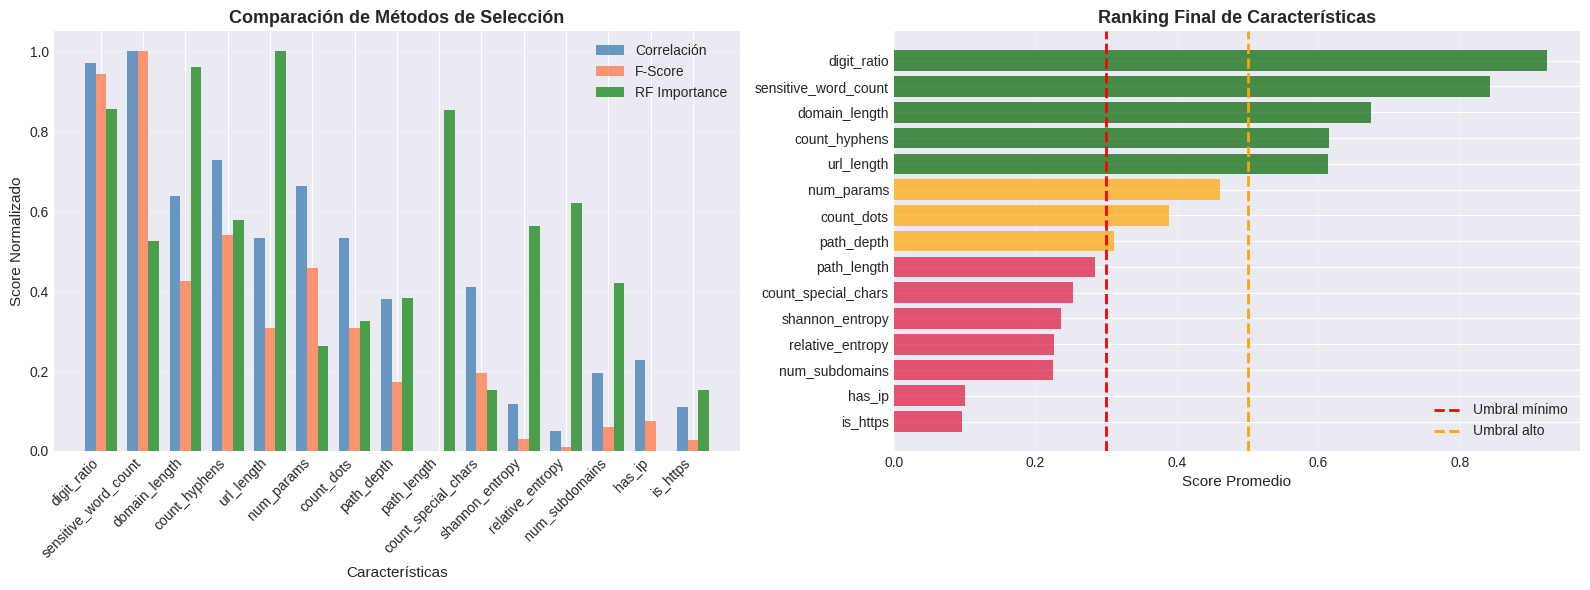

 Gráfico guardado: feature_selection_analysis.png

SELECCIÓN FINAL

 CARACTERÍSTICAS SELECCIONADAS: 8/15

Detalle:
    1. digit_ratio               | Score: 0.924 | Corr: 0.281 | P-val: 6.58e-152
    2. sensitive_word_count      | Score: 0.842 | Corr: 0.288 | P-val: 2.48e-160
    3. domain_length             | Score: 0.675 | Corr: 0.194 | P-val: 1.35e-71
    4. count_hyphens             | Score: 0.616 | Corr: 0.217 | P-val: 5.88e-90
    5. url_length                | Score: 0.614 | Corr: 0.166 | P-val: 3.98e-53
    6. num_params                | Score: 0.460 | Corr: 0.200 | P-val: 1.16e-76
    7. count_dots                | Score: 0.388 | Corr: 0.166 | P-val: 6.03e-53
    8. path_depth                | Score: 0.311 | Corr: 0.126 | P-val: 4.69e-31

 CARACTERÍSTICAS ELIMINADAS: 7
   1. path_length               | Razón: Score bajo (0.284), Corr débil (0.027)
   2. count_special_chars       | Razón: Score bajo (0.253)
   3. has_ip                    | Razón: Score bajo (0.101)
   4. num_s

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("husl")

print("SELECCIÓN DE CARACTERÍSTICAS")

# CARGAR DATOS
df = pd.read_csv('dataset_preprocessed.csv')
X = df.drop('status', axis=1)
y = df['status']

print(f"\n Dataset original:")
print(f"   Shape: {df.shape}")
print(f"   Características: {X.shape[1]}")


# ANÁLISIS
print("\n" + "=" * 80)
print("ANÁLISIS DE IMPORTANCIA")
print("=" * 80)

# Método 1: Correlación con target
correlations = X.corrwith(y).abs()

# Método 2: ANOVA F-test
f_scores, p_values = f_classif(X, y)

# Método 3: Random Forest Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)
rf_importances = rf.feature_importances_

# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Feature': X.columns,
    'Correlation': correlations.values,
    'F-Score': f_scores,
    'P-Value': p_values,
    'RF_Importance': rf_importances
})

# Normalizar scores (0-1)
for col in ['Correlation', 'F-Score', 'RF_Importance']:
    comparison_df[f'{col}_norm'] = (comparison_df[col] - comparison_df[col].min()) / \
                                    (comparison_df[col].max() - comparison_df[col].min())

# Score promedio
comparison_df['Average_Score'] = comparison_df[
    ['Correlation_norm', 'F-Score_norm', 'RF_Importance_norm']
].mean(axis=1)

comparison_df = comparison_df.sort_values('Average_Score', ascending=False)

print("\nRanking de características:")
print(comparison_df[['Feature', 'Average_Score', 'Correlation', 'P-Value']].to_string())

# VISUALIZACIÓN: COMPARACIÓN DE MÉTODOS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparación de métodos
x_pos = np.arange(len(comparison_df))
width = 0.25

ax1.bar(x_pos - width, comparison_df['Correlation_norm'], width,
        label='Correlación', alpha=0.8, color='steelblue')
ax1.bar(x_pos, comparison_df['F-Score_norm'], width,
        label='F-Score', alpha=0.8, color='coral')
ax1.bar(x_pos + width, comparison_df['RF_Importance_norm'], width,
        label='RF Importance', alpha=0.8, color='forestgreen')

ax1.set_xlabel('Características', fontsize=11)
ax1.set_ylabel('Score Normalizado', fontsize=11)
ax1.set_title('Comparación de Métodos de Selección', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Score promedio
colors = ['darkgreen' if score > 0.5 else 'orange' if score > 0.3 else 'crimson'
          for score in comparison_df['Average_Score']]
ax2.barh(comparison_df['Feature'], comparison_df['Average_Score'], color=colors, alpha=0.7)
ax2.set_xlabel('Score Promedio', fontsize=11)
ax2.set_title('Ranking Final de Características', fontsize=13, fontweight='bold')
ax2.axvline(x=0.3, color='red', linestyle='--', linewidth=2, label='Umbral mínimo')
ax2.axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Umbral alto')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Gráfico guardado: feature_selection_analysis.png")

# SELECCIÓN DE CARACTERÍSTICAS
print("\n" + "=" * 80)
print("SELECCIÓN FINAL")
print("=" * 80)

# Criterios de selección:
# - Average_Score > 0.3
# - Correlation > 0.05
# - P-Value < 0.05 (estadísticamente significativa)

selected_features = comparison_df[
    (comparison_df['Average_Score'] > 0.3) &
    (comparison_df['Correlation'] > 0.05) &
    (comparison_df['P-Value'] < 0.05)
]['Feature'].tolist()

print(f"\n CARACTERÍSTICAS SELECCIONADAS: {len(selected_features)}/{len(X.columns)}")
print("\nDetalle:")
for i, feature in enumerate(selected_features, 1):
    row = comparison_df[comparison_df['Feature'] == feature].iloc[0]
    print(f"   {i:2d}. {feature:25s} | Score: {row['Average_Score']:.3f} | "
          f"Corr: {row['Correlation']:.3f} | P-val: {row['P-Value']:.2e}")

eliminated = [f for f in X.columns if f not in selected_features]
if eliminated:
    print(f"\n CARACTERÍSTICAS ELIMINADAS: {len(eliminated)}")
    for i, feature in enumerate(eliminated, 1):
        row = comparison_df[comparison_df['Feature'] == feature].iloc[0]
        reasons = []
        if row['Average_Score'] <= 0.3:
            reasons.append(f"Score bajo ({row['Average_Score']:.3f})")
        if row['Correlation'] <= 0.05:
            reasons.append(f"Corr débil ({row['Correlation']:.3f})")
        if row['P-Value'] >= 0.05:
            reasons.append(f"No significativa (p={row['P-Value']:.3f})")
        print(f"   {i}. {feature:25s} | Razón: {', '.join(reasons)}")
else:
    print("\n Todas las características fueron seleccionadas")

# ACTUALIZAR DATASETS EXISTENTES
print("\n" + "=" * 80)
print("ACTUALIZANDO DATASETS")
print("=" * 80)

# Actualizar dataset sin normalizar
df_updated = df[selected_features + ['status']].copy()
df_updated.to_csv('dataset_preprocessed.csv', index=False)
print(f"\n dataset_preprocessed.csv actualizado")
print(f"   Shape anterior: {df.shape}")
print(f"   Shape nuevo: {df_updated.shape}")
print(f"   Características eliminadas: {df.shape[1] - df_updated.shape[1]}")

# Actualizar dataset normalizado
df_scaled = pd.read_csv('dataset_preprocessed_scaled.csv')
df_scaled_updated = df_scaled[selected_features + ['status']].copy()
df_scaled_updated.to_csv('dataset_preprocessed_scaled.csv', index=False)
print(f"\n dataset_preprocessed_scaled.csv actualizado")
print(f"   Shape: {df_scaled_updated.shape}")



3. **¿Qué columnas o características fueron seleccionadas y por qué?**


La selección de características se realizó mediante tres métodos complementarios: Correlación de Pearson, ANOVA F-test y Random Forest Feature Importance. Se consideró relevante una característica si cumplía con los siguientes criterios: score promedio normalizado > 0.3, correlación absoluta > 0.05 y p-value < 0.05.

De las 15 características originales, se seleccionaron 8 por presentar el mayor poder discriminativo entre URLs legítimas y de phishing:
* digit_ratio (score: 0.924, corr: 0.281): fue la característica más importante, ya que las URLs de phishing suelen incluir más dígitos para generar variantes engañosas de dominios conocidos.

* sensitive_word_count (score: 0.842, corr: 0.288): detecta palabras clave asociadas a instituciones financieras, servicios populares o términos de urgencia usados para generar confianza.

* domain_length (score: 0.675, corr: 0.194): identifica dominios excesivamente largos, típicos del phishing que intenta imitar marcas legítimas.

* count_hyphens (score: 0.616, corr: 0.217): captura el uso de guiones, una técnica común de typosquatting.

* url_length (score: 0.614, corr: 0.166): mide la longitud total de la URL, generalmente mayor en sitios de phishing debido a subdominios y parámetros adicionales.

* num_params (score: 0.460, corr: 0.200): contabiliza los parámetros de la URL, útil para detectar cadenas query sospechosas.

* count_dots (score: 0.388, corr: 0.166): identifica la presencia de múltiples puntos, indicativos de subdominios anidados.

* path_depth (score: 0.311, corr: 0.126): mide la profundidad de la estructura de directorios.

Se descartaron 7 características por baja relevancia estadística o importancia predictiva: path_length (correlación muy débil), shannon_entropy y relative_entropy (scores bajos), así como count_special_chars, num_subdomains, has_ip e is_https, todas por debajo del umbral establecido.